In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as st

In [2]:
# Constants
CONSTANT_lL = 0.15
CONSTANT_Ld95 = 30

CONSTANT_ma = 0.015
CONSTANT_mr = 4.2
CONSTANT_mt = 2.75

CONSTANT_Cf = 0.5
CONSTANT_Cg = 0.25

In [3]:
def get_l_factor(L=CONSTANT_lL, d95=CONSTANT_Ld95):
    """Returns the l factor

    Args:
        L (float, optional): liberation size in cm, 150 microns from p80 of rougher flotation feed. 
        Assume as p80 of the rougher floation feed. Defaults to 0.15.
        d95 (int, optional): 95% passing in cm. Bern estimates 30 cm - 100 cm. Defaults to 30.

    Returns:
        float: l_factor
    """
    return np.sqrt(L / d95)

def get_m_factor(a=CONSTANT_ma, r=CONSTANT_mr, t=CONSTANT_mt):
    """Returns the m factor

    Args:
        a (float, optional): average grade as a decimal. Defaults to 0.015 (1.5%).
        r (float, optional): mineral density. Use the density for chalcopyrite. Defaults to 4.2.
        t (float, optional): gangue density. From the Minesense Amenability Study Table 1. Defaults to 2.75.

    Returns:
        _type_: _description_
    """
    return (1 - a) / a * ((1 - a) * r + a * t)

def get_C_factor(f=CONSTANT_Cf, g=CONSTANT_Cg, l=get_l_factor(), m=get_m_factor()):
    """returns C factor from params f, g, l, m

    Args:
        f (float, optional): f factor, 0.5 for non-gold. 0.2 for gold. Defaults to 0.5.
        g (float, optional): g factor, as size ration increases, g decreases. Defaults to 0.25.
        l (float, optional): l factor. Defaults to get_l_factor().
        m (float, optional): m factor. Defaults to get_m_factor().

    Returns:
        float: returns the C factor
    """
    return f * g * l * m

def sigmas_from_conf(conf):
    """returns the number of standard deviations from the mean with a given confidence interval
    i.e. with a 95% conf interval (conf = 0.95), function will return 1.96, meaning a 95% confidence that the
    value is at most 1.96 stds (Z) away from the mean.

    Args:
        conf (float): confidence interval as a decimal

    Returns:
        float: number of stds away from the mean the actual value is away from the calculated value within the given confindence interval
    """
    return st.norm.ppf(1 - (1 - conf) / 2)

def sigma_from_params(conf_int, moe, grade):
    """Returns the value of sigma given a confidence interval, range, and average grade. This value can be fed into other 
    formulas to determine the minimum sample size.

    Args:
        conf_int (float): Confidence interval as a decimal percentage: 95% is 0.95
        conf_range (float): Range for the given confidence interval: 95% confident that the value is within 0.2% of the true value
        grade (float): Average grade of the distribution

    Returns:
        float: A sigma value: sigma = 0.01 (i.e. 1% error)
    """
    return (moe / grade) / sigmas_from_conf(conf_int)

def sample_mass_from_params(C, d95, sigma):
    """Return the minimum sample mass (in grams) to achieve the required degree of confidence & other errors associated

    Args:
        C (float): C value in g/cm^3
        d95 (float): 95% passing size of the distribution in cm
        sigma (float): sigma value

    Returns:
        _type_: _description_
    """
    return C * d95**3 / sigma**2

In [4]:
get_C_factor()

2.4251265623877516

In [5]:
Ms = 30 # kg
variation = get_C_factor() / Ms
sigma = np.sqrt(variation)

In [6]:
sigma

0.2843194542756294

In [7]:
1.5 * (sigma / 2)  

0.21323959070672205

In [8]:
st.norm.cdf(sigma)

0.61191721064182

In [9]:
sigmas_from_conf(0.95)

1.959963984540054

In [10]:
d = .30
(get_C_factor() * (d**3)) / (sigmas_from_conf(0.90) ** 2)

0.0242015766131399

In [11]:
(get_C_factor() * 30**3) / sigmas_from_conf(0.90)

39808.05107006709

# Sample Calculation

Consider a copper ore, assaying ~ 1.5 % Cu, which must be routinely sampled on crusher product for assay to a 90% confidence level of +/- 0.1% Cu. 


In [12]:
# Solution
# Relative precision sigma in relative terms is calculated from :
#    X * sigma {or the confidence interval, x = ~2 if confidendence interval is 95%} = deviation from mean / mean percentage
# 1.96 sigma = 0.1 % / 1.5% in the example above

confidence_level = 0.90 # * 100%
confidence_range = 0.15 # %
average_grade = 1.5 # %

sigma = (confidence_range / average_grade) / sigmas_from_conf(confidence_level)
sigma

0.06079568319117691

In [13]:
d95 = 30
C = get_C_factor(
    f=0.5,
    g=0.25,
    l=get_l_factor(
        L=0.15,
        d95=d95
    ),
    m=get_m_factor(
        a=0.015,
        r=4.2,
        t=2.75
    )
)

mass_in_grams = sample_mass_from_params(C, d95, sigma)
print(f'{mass_in_grams / 1000:0.2f} kgs')

17715.47 kgs


In [14]:
d95 = 2.5
sigma = sigma_from_params(0.95, 0.1, 5)
C = get_C_factor(
    f=0.5,
    g=0.25,
    l=get_l_factor(
        L=0.015,
        d95=d95
    ),
    m=get_m_factor(
        a=0.058,
        r=7.6,
        t=2.65
    )
)
mass_in_grams = sample_mass_from_params(C, d95, sigma)
mass_in_grams / 1000

172.56566877250697

## Calculations

Test a variety of different precision and confidence intervals in addition to modifying assumed values slightly

In [15]:
# Can vary confidence level, starting at 95% and decreasing
# An average grade of 1.5% Cu remains unchanged, however the confidence range can change.
# While the precision of minesense is said to be quite high, accuracy matters much more, and we can see the estimated minimum sample size
# for various ranges of confidence. Start at 0.1% Cu and increase

confidence_level = 0.90 # * 100%
confidence_range = 0.15 # %
average_grade = 1.5 # %

sigma = (confidence_range / average_grade) / sigmas_from_conf(confidence_level)
sigma

0.06079568319117691

In [16]:
d95 = 30 # 95 % passing of the lot in cm, can vary from 10 cm - 100 cm
C = get_C_factor(
    f=0.5, # Does not vary
    g=0.25, # Should not vary
    l=get_l_factor(
        L=0.15, # Liberation size in cm. Can attempt to vary from 0.1-0.2
        d95=d95
    ),
    m=get_m_factor(
        a=0.015, # Average grade, should not change from 1.5%
        r=4.2, # SG of mineral, should remain the same, but could vary from 4.1-4.2
        t=2.75 # SG of gangue, should remain the same, but could try varying from 2.7-2.8
    )
)

mass_in_grams = sample_mass_from_params(C, d95, sigma)
print(f'{mass_in_grams / 1000:0.2f} kgs')

17715.47 kgs


In [17]:
confidence_levels = [0.95, 0.9, 0.85, 0.8, 0.75] # *100%
confidence_ranges = [0.1, 0.15, 0.2] # %
average_grade = 1.5

sigmas = []
for confidence_level in confidence_levels:
    for confidence_range in confidence_ranges:
        sigmas.append(sigma_from_params(confidence_level, confidence_range, average_grade))

In [18]:
d95s = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Cs = []
for d95 in d95s:
    Cs.append(get_C_factor(
        f=0.5, # Does not vary
        g=0.25, # Should not vary
        l=get_l_factor(
            L=0.15, # Liberation size in cm. Can attempt to vary from 0.1-0.2
            d95=d95
        ),
        m=get_m_factor(
            a=0.015, # Average grade, should not change from 1.5%
            r=4.2, # SG of mineral, should remain the same, but could vary from 4.1-4.2
            t=2.75 # SG of gangue, should remain the same, but could try varying from 2.7-2.8
        )
    ))

sample_sizes = []

        
for C in Cs:
    for d95 in d95s:
        for sigma in sigmas:
            sample_sizes.append(sample_mass_from_params(C, d95, sigma) / 1e6)

In [19]:
pd.Series(sample_sizes).describe()

count    1500.000000
mean      187.854892
std       314.285144
min         0.098873
25%        11.254296
50%        69.697215
75%       225.963898
max      3630.560982
dtype: float64

## Dataframed

In [20]:
columns = [
    'confidence_level', 
    'margin_of_error',
    'average_grade',
    'sigma',
    'd95',
    'f',
    'g',
    'lL',
    'ma',
    'mr',
    'mt',
    'min_sample_size'
    ]
data = []

confidence_levels = [0.95, 0.9, 0.85, 0.8, 0.75] # *100%
confidence_ranges = [0.05, 0.1, 0.15, 0.2] # %
average_grade = 1.5
d95s = np.arange(10, 102, 2)  # 25-75 cm?
# [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lLs = [0.1, 0.15, 0.2]
mrs = [4.1, 4.15, 4.2]
mts = [2.7, 2.75, 2.8]

In [131]:
confidence_levels = [0.9] # *100%
confidence_ranges = [0.05, 0.1, 0.2] # %
average_grade = 1.5
d95s = [5, 30, 50, 100]
# [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lLs = [.15]
mrs = [4.15]
mts = [2.75]

In [132]:
data = []
for L in lLs:
    for r in mrs:
        for t in mts:
            for d95 in d95s:
                C = get_C_factor(
                    f=CONSTANT_Cf, # Does not vary, set at 0.5
                    g=0.25, # Should not vary, set at 0.25
                    l=get_l_factor(
                        L=L, # Liberation size in cm. Can attempt to vary from 0.1-0.2
                        d95=d95
                    ),
                    m=get_m_factor(
                        a=0.015, # Average grade, should not change from 1.5%
                        r=r, # SG of mineral, should remain the same, but could vary from 4.1-4.2
                        t=t # SG of gangue, should remain the same, but could try varying from 2.7-2.8
                    )
                )
                for confidence_level in confidence_levels:
                    for confidence_range in confidence_ranges:
                        sigma = sigma_from_params(confidence_level, confidence_range, average_grade)
                        sample_size = sample_mass_from_params(C, d95, sigma) / 1e6
                        
                        data.append([
                            confidence_level,
                            confidence_range,
                            average_grade,
                            sigma,
                            d95,
                            CONSTANT_Cf,
                            CONSTANT_Cg,
                            L, # L
                            0.015, # a
                            r, # r
                            t, # t
                            sample_size
                        ])                
            
df = pd.DataFrame(data, columns=columns)
df

,confidence_level,margin_of_error,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
0,0.9,0.05,1.5,0.020265,5,0.5,0.25,0.15,0.015,4.15,2.75,1.786765
1,0.9,0.10,1.5,0.040530,5,0.5,0.25,0.15,0.015,4.15,2.75,0.446691
2,0.9,0.20,1.5,0.081061,5,0.5,0.25,0.15,0.015,4.15,2.75,0.111673
3,0.9,0.05,1.5,0.020265,30,0.5,0.25,0.15,0.015,4.15,2.75,157.559886
4,0.9,0.10,1.5,0.040530,30,0.5,0.25,0.15,0.015,4.15,2.75,39.389971
5,0.9,0.20,1.5,0.081061,30,0.5,0.25,0.15,0.015,4.15,2.75,9.847493
6,0.9,0.05,1.5,0.020265,50,0.5,0.25,0.15,0.015,4.15,2.75,565.024827
7,0.9,0.10,1.5,0.040530,50,0.5,0.25,0.15,0.015,4.15,2.75,141.256207
8,0.9,0.20,1.5,0.081061,50,0.5,0.25,0.15,0.015,4.15,2.75,35.314052
9,0.9,0.05,1.5,0.020265,100,0.5,0.25,0.15,0.015,4.15,2.75,3196.263092


In [23]:
df['min_sample_size'].describe()

count       4.000000
mean     1175.402474
std      1374.472787
min       141.256207
25%       459.082672
50%       682.045300
75%      1398.365103
max      3196.263092
Name: min_sample_size, dtype: float64

In [24]:
df[df['min_sample_size'] <= 15].describe()

,confidence_level,margin_of_error,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'confidence_level'}>,
        <AxesSubplot:title={'center':'margin_of_error'}>],
       [<AxesSubplot:title={'center':'d95'}>,
        <AxesSubplot:title={'center':'min_sample_size'}>]], dtype=object)

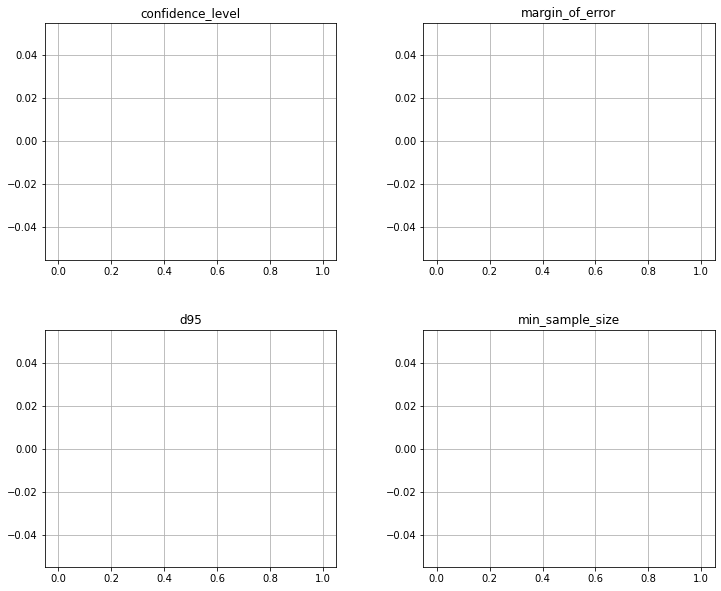

In [25]:
df[
    df['min_sample_size'] <= 10
][[
    'confidence_level',
    'margin_of_error',
    'd95',
    'min_sample_size'
]].hist(figsize=(12, 10))

In [26]:
df[df['min_sample_size'] <= 2.5].describe()

,confidence_level,margin_of_error,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Reverse

In [117]:
r_sigmas, r_zs, r_crs = [], [], []
Ms = [35000, 35000*10, 35000*100, 35000*1000]
d95s = [1, 3, 5, 30, 50, 100]
moe = 0.2

for C in Cs:
    for m in Ms:
        for d95 in d95s:
            sigma = np.sqrt(C * d95**3 / (m / 2))  # divide by two bc the min sample size is half of the suggested
            r_sigmas.append(sigma)
            z = 0.05 / (1.5 * sigma)  # within 0.05% Cu
            r_zs.append(z)
            r_crs.append((st.norm.cdf(z) - 0.5) * 2)

In [118]:
data = []
for L in lLs:
    for r in mrs:
        for t in mts:
            for d95 in d95s:
                C = get_C_factor(
                    f=CONSTANT_Cf, # Does not vary, set at 0.5
                    g=0.25, # Should not vary, set at 0.25
                    l=get_l_factor(
                        L=L, # Liberation size in cm. Can attempt to vary from 0.1-0.2
                        d95=d95
                    ),
                    m=get_m_factor(
                        a=0.015, # Average grade, should not change from 1.5%
                        r=r, # SG of mineral, should remain the same, but could vary from 4.1-4.2
                        t=t # SG of gangue, should remain the same, but could try varying from 2.7-2.8
                    )
                )
                for m in Ms:
                    sigma = np.sqrt(C * d95**3 / (m / 2))  # divide by two bc the min sample size is usually half of the suggested
                    z = moe / (1.5 * sigma)  # within 0.2% Cu
                        
                    data.append([
                        (st.norm.cdf(z) - 0.5) * 2,
                        moe,
                        average_grade,
                        sigma,
                        d95,
                        CONSTANT_Cf,
                        CONSTANT_Cg,
                        L, # L
                        0.015, # a
                        r, # r
                        t, # t
                        m / (2 * 1e6)
                    ])   
                    
r_df = pd.DataFrame(data, columns=columns)

In [119]:
r_df

,confidence_level,margin_of_error,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
0,0.999999,0.2,1.5,0.027388,1,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
1,1.000000,0.2,1.5,0.008661,1,0.5,0.25,0.15,0.015,4.15,2.75,0.1750
2,1.000000,0.2,1.5,0.002739,1,0.5,0.25,0.15,0.015,4.15,2.75,1.7500
3,1.000000,0.2,1.5,0.000866,1,0.5,0.25,0.15,0.015,4.15,2.75,17.5000
4,0.782446,0.2,1.5,0.108132,3,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
5,0.999904,0.2,1.5,0.034194,3,0.5,0.25,0.15,0.015,4.15,2.75,0.1750
6,1.000000,0.2,1.5,0.010813,3,0.5,0.25,0.15,0.015,4.15,2.75,1.7500
7,1.000000,0.2,1.5,0.003419,3,0.5,0.25,0.15,0.015,4.15,2.75,17.5000
8,0.485042,0.2,1.5,0.204770,5,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
9,0.960513,0.2,1.5,0.064754,5,0.5,0.25,0.15,0.015,4.15,2.75,0.1750


### Reverse within 90% conf

In [120]:
r_sigmas, r_zs, r_crs = [], [], []
# Ms = [35000, 35000*10, 35000*100, 35000*1000]
# d95s = [5, 30, 50, 100]

for C in Cs:
    for m in Ms:
        for d95 in d95s:
            sigma = np.sqrt(C * d95**3 / (m / 2))  # divide by two bc the min sample size is usually half of the suggested
            r_sigmas.append(sigma)
            z = 0.05 / (1.5 * sigma)  # within 0.05% Cu
            r_zs.append(z)
            r_crs.append((st.norm.cdf(z) - 0.5) * 2)

In [121]:
conf = 0.9
a = 0.015

data = []
for L in lLs:
    for r in mrs:
        for t in mts:
            for d95 in d95s:
                C = get_C_factor(
                    f=CONSTANT_Cf, # Does not vary, set at 0.5
                    g=0.25, # Should not vary, set at 0.25
                    l=get_l_factor(
                        L=L, # Liberation size in cm. Can attempt to vary from 0.1-0.2
                        d95=d95
                    ),
                    m=get_m_factor(
                        a=a, # Average grade, should not change from 1.5%
                        r=r, # SG of mineral, should remain the same, but could vary from 4.1-4.2
                        t=t # SG of gangue, should remain the same, but could try varying from 2.7-2.8
                    )
                )
                for m in Ms:
                    sigma = np.sqrt(C * d95**3 / (m / 2))  # divide by two bc the min sample size is usually half of the suggested
                    z = sigmas_from_conf(conf)
                        
                    data.append([
                        conf, # (st.norm.cdf(z) - 0.5) * 2
                        sigma * average_grade * z,
                        average_grade,
                        sigma,
                        d95,
                        CONSTANT_Cf,
                        CONSTANT_Cg,
                        L, # L
                        0.015, # a
                        r, # r
                        t, # t
                        m / (2 * 1e6)
                    ])   
                    
r_df = pd.DataFrame(data, columns=columns)

In [122]:
print(sigmas_from_conf(0.9))

1.6448536269514722


In [123]:
r_df

,confidence_level,margin_of_error,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
0,0.9,0.067573,1.5,0.027388,1,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
1,0.9,0.021368,1.5,0.008661,1,0.5,0.25,0.15,0.015,4.15,2.75,0.1750
2,0.9,0.006757,1.5,0.002739,1,0.5,0.25,0.15,0.015,4.15,2.75,1.7500
3,0.9,0.002137,1.5,0.000866,1,0.5,0.25,0.15,0.015,4.15,2.75,17.5000
4,0.9,0.266793,1.5,0.108132,3,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
5,0.9,0.084367,1.5,0.034194,3,0.5,0.25,0.15,0.015,4.15,2.75,0.1750
6,0.9,0.026679,1.5,0.010813,3,0.5,0.25,0.15,0.015,4.15,2.75,1.7500
7,0.9,0.008437,1.5,0.003419,3,0.5,0.25,0.15,0.015,4.15,2.75,17.5000
8,0.9,0.505225,1.5,0.204770,5,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
9,0.9,0.159766,1.5,0.064754,5,0.5,0.25,0.15,0.015,4.15,2.75,0.1750


In [124]:
pd.Series(r_crs).describe()

count    240.000000
mean       0.472744
std        0.431628
min        0.001717
25%        0.032401
50%        0.294491
75%        0.999894
max        1.000000
dtype: float64

<AxesSubplot:>

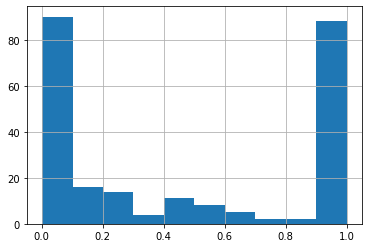

In [125]:
pd.Series(r_crs).hist()

array([[<AxesSubplot:title={'center':'confidence_level'}>,
        <AxesSubplot:title={'center':'margin_of_error'}>,
        <AxesSubplot:title={'center':'average_grade'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'d95'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'lL'}>,
        <AxesSubplot:title={'center':'ma'}>],
       [<AxesSubplot:title={'center':'mr'}>,
        <AxesSubplot:title={'center':'mt'}>,
        <AxesSubplot:title={'center':'min_sample_size'}>]], dtype=object)

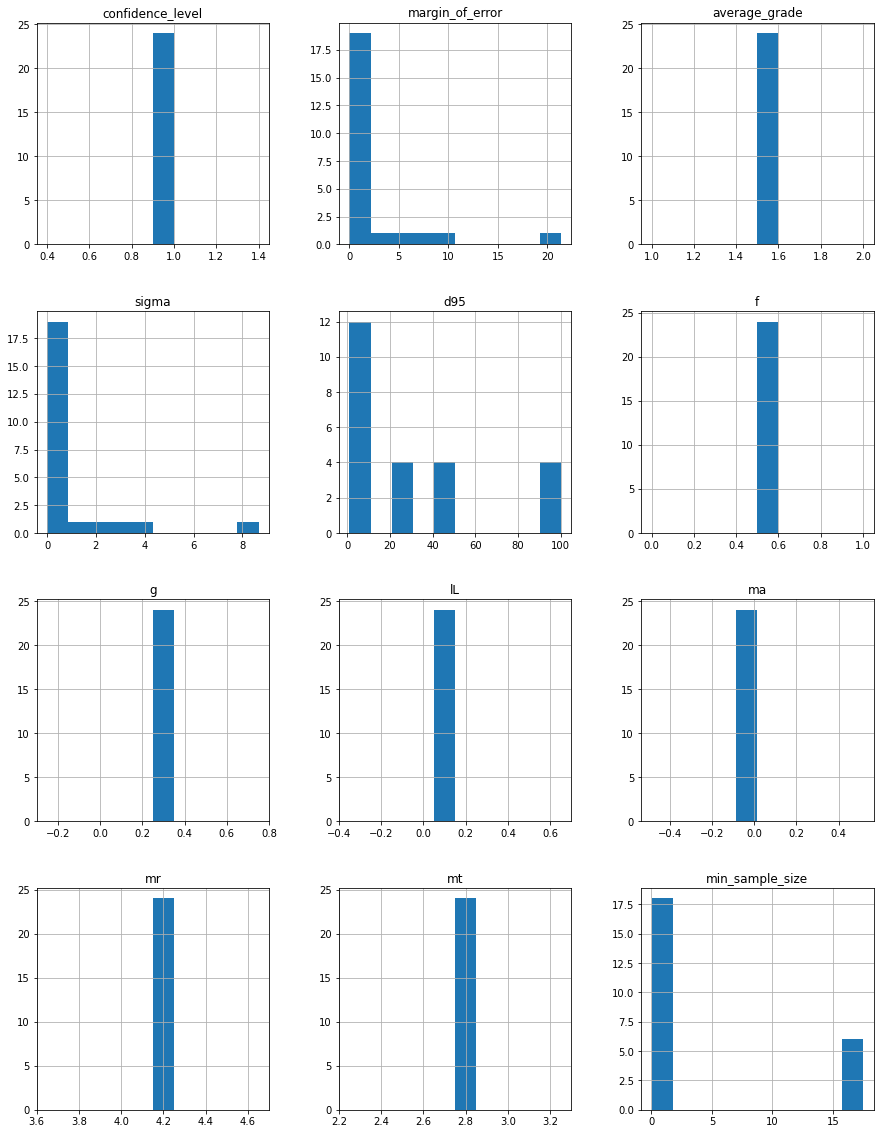

In [126]:
r_df.hist(figsize=(15, 20))

In [127]:
r_df.describe()

,confidence_level,margin_of_error,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
count,2.400000e+01,24.000000,24.0,24.000000,24.000000,24.0,24.00,2.400000e+01,2.400000e+01,2.400000e+01,24.00,24.000000
mean,9.000000e-01,2.167953,1.5,0.878681,31.500000,0.5,0.25,1.500000e-01,1.500000e-02,4.150000e+00,2.75,4.860625
std,2.268203e-16,4.706815,0.0,1.907693,36.071186,0.0,0.00,5.670508e-17,8.860168e-18,9.072812e-16,0.00,7.486348
min,9.000000e-01,0.002137,1.5,0.000866,1.000000,0.5,0.25,1.500000e-01,1.500000e-02,4.150000e+00,2.75,0.017500
25%,9.000000e-01,0.044562,1.5,0.018061,3.000000,0.5,0.25,1.500000e-01,1.500000e-02,4.150000e+00,2.75,0.135625
50%,9.000000e-01,0.275451,1.5,0.111641,17.500000,0.5,0.25,1.500000e-01,1.500000e-02,4.150000e+00,2.75,0.962500
75%,9.000000e-01,1.659424,1.5,0.672572,50.000000,0.5,0.25,1.500000e-01,1.500000e-02,4.150000e+00,2.75,5.687500
max,9.000000e-01,21.368412,1.5,8.660715,100.000000,0.5,0.25,1.500000e-01,1.500000e-02,4.150000e+00,2.75,17.500000


In [128]:
r_df[r_df['confidence_level'] == r_df['confidence_level'].max()]

,confidence_level,margin_of_error,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
0,0.9,0.067573,1.5,0.027388,1,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
1,0.9,0.021368,1.5,0.008661,1,0.5,0.25,0.15,0.015,4.15,2.75,0.1750
2,0.9,0.006757,1.5,0.002739,1,0.5,0.25,0.15,0.015,4.15,2.75,1.7500
3,0.9,0.002137,1.5,0.000866,1,0.5,0.25,0.15,0.015,4.15,2.75,17.5000
4,0.9,0.266793,1.5,0.108132,3,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
5,0.9,0.084367,1.5,0.034194,3,0.5,0.25,0.15,0.015,4.15,2.75,0.1750
6,0.9,0.026679,1.5,0.010813,3,0.5,0.25,0.15,0.015,4.15,2.75,1.7500
7,0.9,0.008437,1.5,0.003419,3,0.5,0.25,0.15,0.015,4.15,2.75,17.5000
8,0.9,0.505225,1.5,0.204770,5,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
9,0.9,0.159766,1.5,0.064754,5,0.5,0.25,0.15,0.015,4.15,2.75,0.1750


# Calculate with absolute M


m = MCd^3 / [sigma^2 * M + Cd^3]

In [76]:
r_sigmas, r_zs, r_crs = [], [], []
Ms = [500, 1000]

confidence_level = 0.90 # *100%
moes = [0.1, 0.2] # %
d95s = [5, 50, 100]


average_grade = 1.5

L = .15
r = 4.15
t = 2.75

In [77]:
sigmas = []
for confidence_level in confidence_levels:
    for confidence_range in confidence_ranges:
        sigmas.append(sigma_from_params(confidence_level, confidence_range, average_grade))

In [78]:
def get_C_from_d95(d95):
    return get_C_factor(
        f=CONSTANT_Cf, # Does not vary, set at 0.5
        g=0.25, # Should not vary, set at 0.25
        l=get_l_factor(
            L=L, # Liberation size in cm. Can attempt to vary from 0.1-0.2
            d95=d95
        ),
        m=get_m_factor(
            a=average_grade / 100, # Average grade, should not change from 1.5%
            r=r, # SG of mineral, should remain the same, but could vary from 4.1-4.2
            t=t # SG of gangue, should remain the same, but could try varying from 2.7-2.8
        )
    )

In [79]:
data = []
columns = [
    'M',
    'margin_of_error',
    'd95',
    'min_sample_size'
]


for d95 in d95s:
    for moe in moes:
        for M in Ms:
            M = M * 1e6
            C = get_C_from_d95(d95)
            sigma = sigma_from_params(confidence_level, moe, average_grade)
            
            m = (M * C * d95**3) / (sigma**2 * M + C * d95**3)
            
            data.append([
                M / 1e6,
                moe, # (st.norm.cdf(z) - 0.5) * 2
                d95,
                m / 1e6
            ])   
        
        # do one for unbounded M
        m = C * d95**3 / sigma**2 
        data.append([
            'unbounded',
            moe, # (st.norm.cdf(z) - 0.5) * 2
            d95,
            m / 1e6
        ])  
                    
r_df = pd.DataFrame(data, columns=columns)
r_df

,M,margin_of_error,d95,min_sample_size
0,500.0,0.1,5,0.446293
1,1000.0,0.1,5,0.446492
2,unbounded,0.1,5,0.446691
3,500.0,0.2,5,0.111648
4,1000.0,0.2,5,0.111660
5,unbounded,0.2,5,0.111673
6,500.0,0.1,50,110.140226
7,1000.0,0.1,50,123.772564
8,unbounded,0.1,50,141.256207
9,500.0,0.2,50,32.984424
